In [10]:
import numpy as np
import pandas as pd
import io
import requests
import re
import warnings
import sklearn
import xgboost as xgb

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import missingno as msno

import seaborn as sns
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter

In [4]:
df_test_raw  = pd.read_csv("tested.csv")
df_test  = df_test_raw.copy(deep = True)

data_cleaner = [df_test_raw]

In [6]:
df_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
varnames = list(df_test.columns)
for name in varnames:
    print(name+": ",type(df_test.loc[1,name]))

PassengerId:  <class 'numpy.int64'>
Survived:  <class 'numpy.int64'>
Pclass:  <class 'numpy.int64'>
Name:  <class 'str'>
Sex:  <class 'str'>
Age:  <class 'numpy.float64'>
SibSp:  <class 'numpy.int64'>
Parch:  <class 'numpy.int64'>
Ticket:  <class 'str'>
Fare:  <class 'numpy.float64'>
Cabin:  <class 'float'>
Embarked:  <class 'str'>


In [8]:
df_test.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

<Axes: >

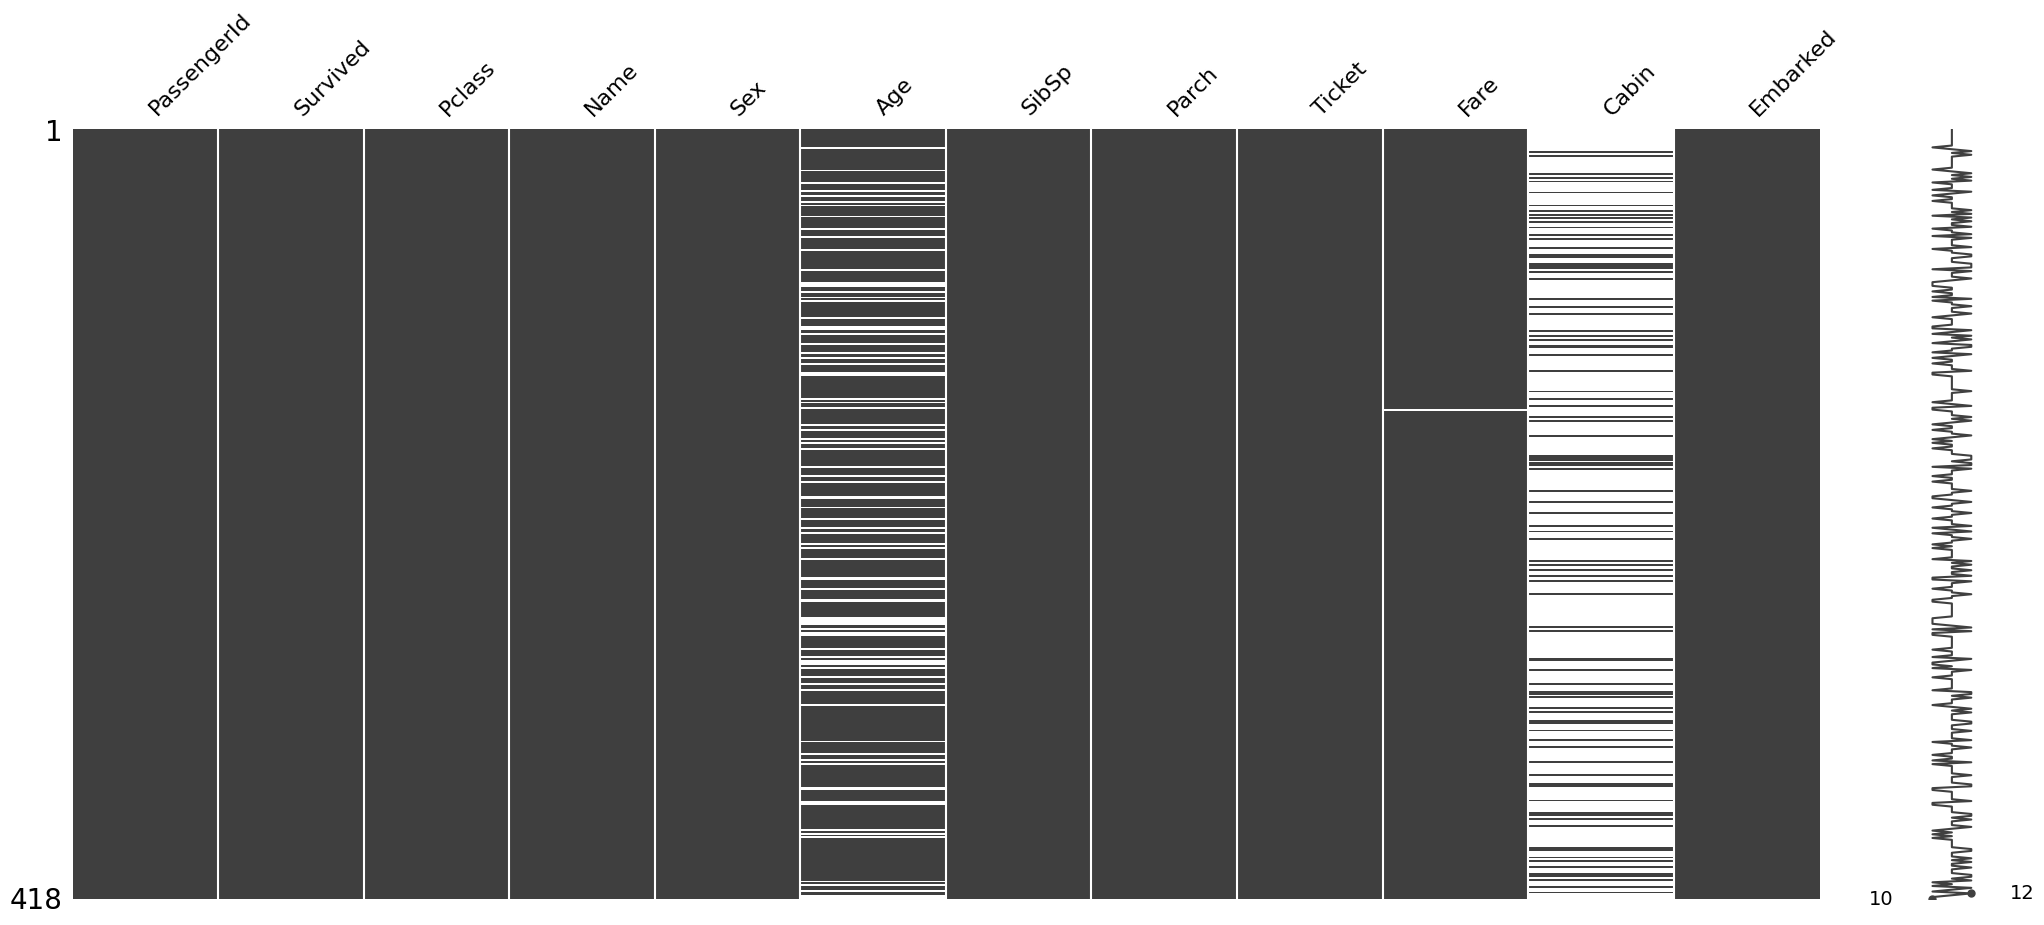

In [11]:
msno.matrix(df_test)

<Axes: >

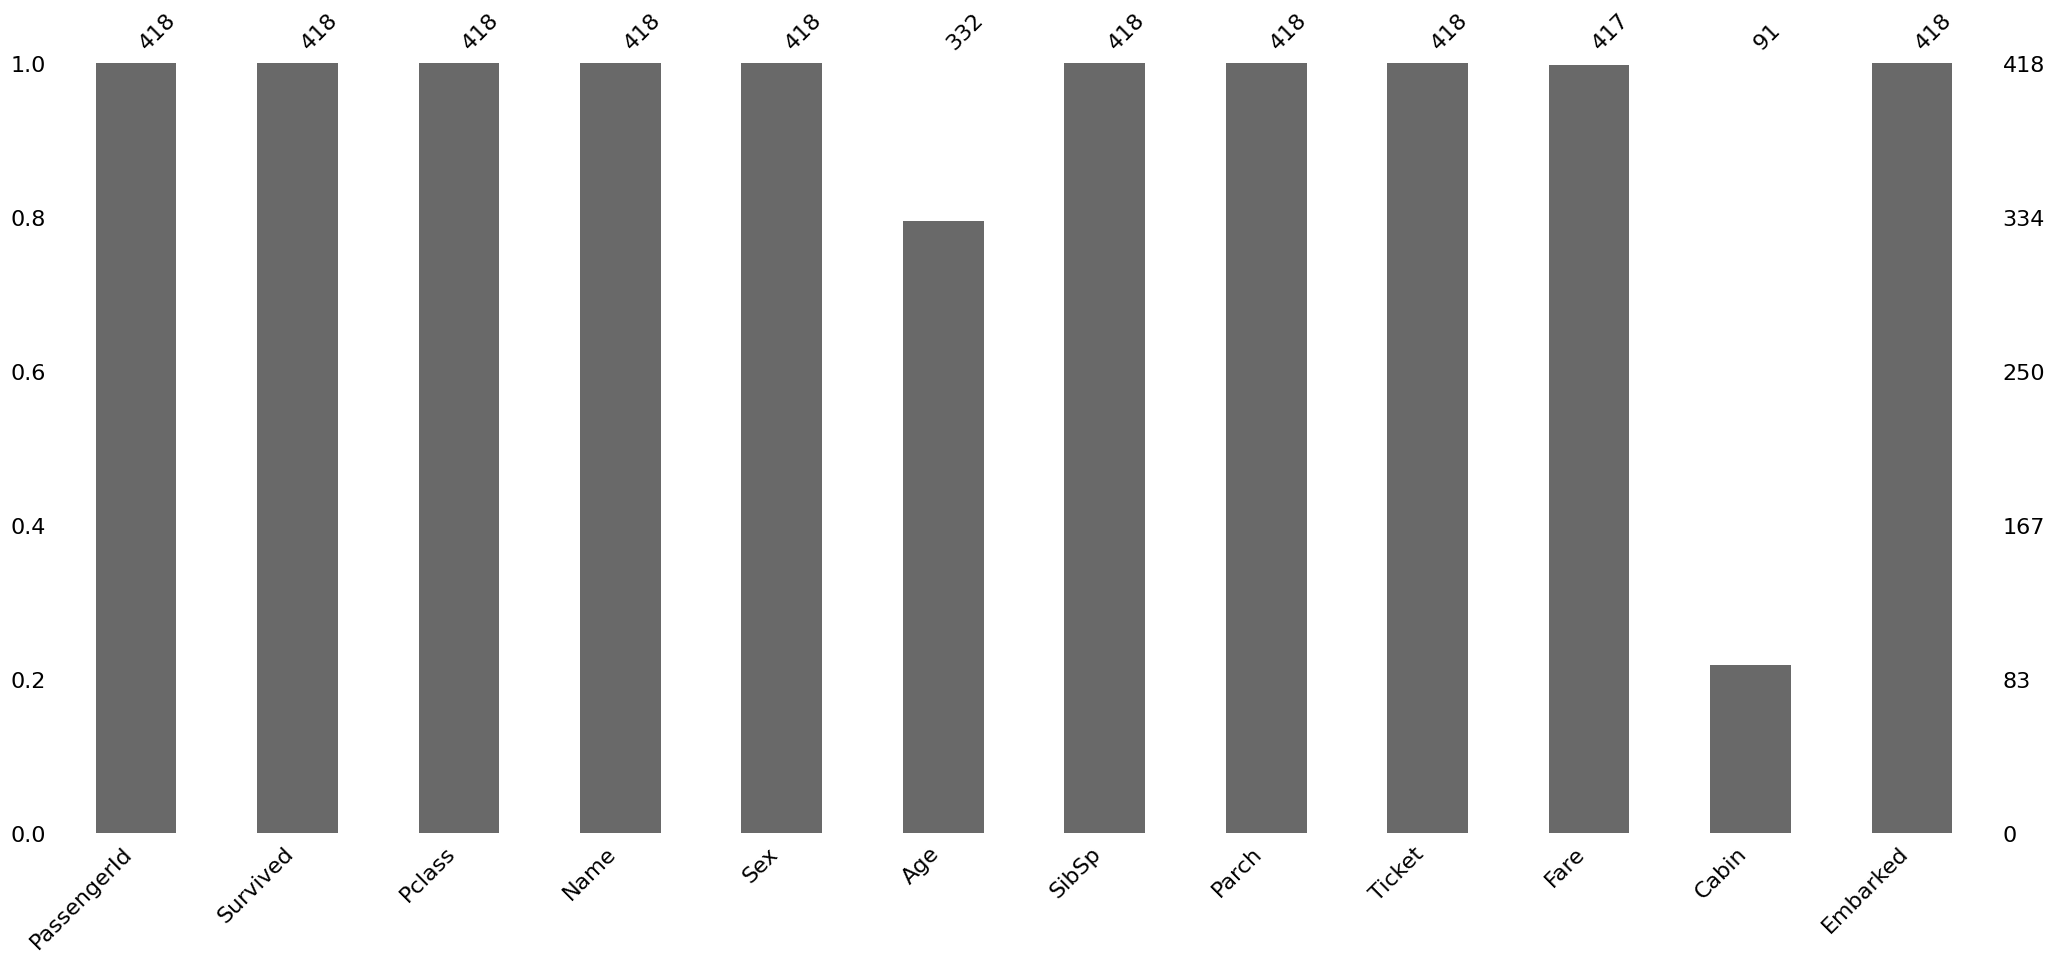

In [12]:
msno.bar(df_test)

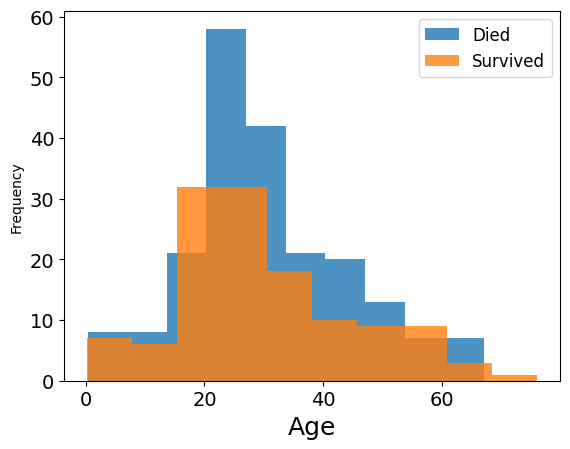

In [14]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

plt.figure()
fig = df_test.groupby('Survived')['Age'].plot.hist(histtype= 'bar', alpha = 0.8)
plt.legend(('Died','Survived'), fontsize = 12)
plt.xlabel('Age', fontsize = 18)
plt.show()

In [15]:
df_test.corr(method='pearson')['Age'].abs()

<ipython-input-15-91a71196b110>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



PassengerId    0.034102
Survived       0.000013
Pclass         0.492143
Age            1.000000
SibSp          0.091587
Parch          0.061249
Fare           0.337932
Name: Age, dtype: float64

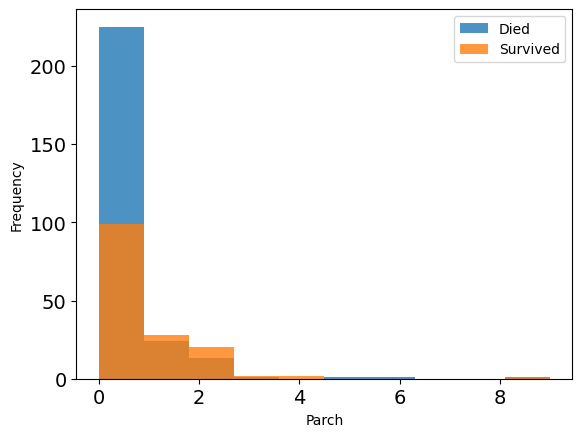

In [16]:
plt.figure()
fig = df_test.groupby('Survived')['Parch'].plot.hist(histtype= 'bar',alpha = 0.8)
plt.legend(('Died','Survived'),)
plt.xlabel('Parch')
plt.show()

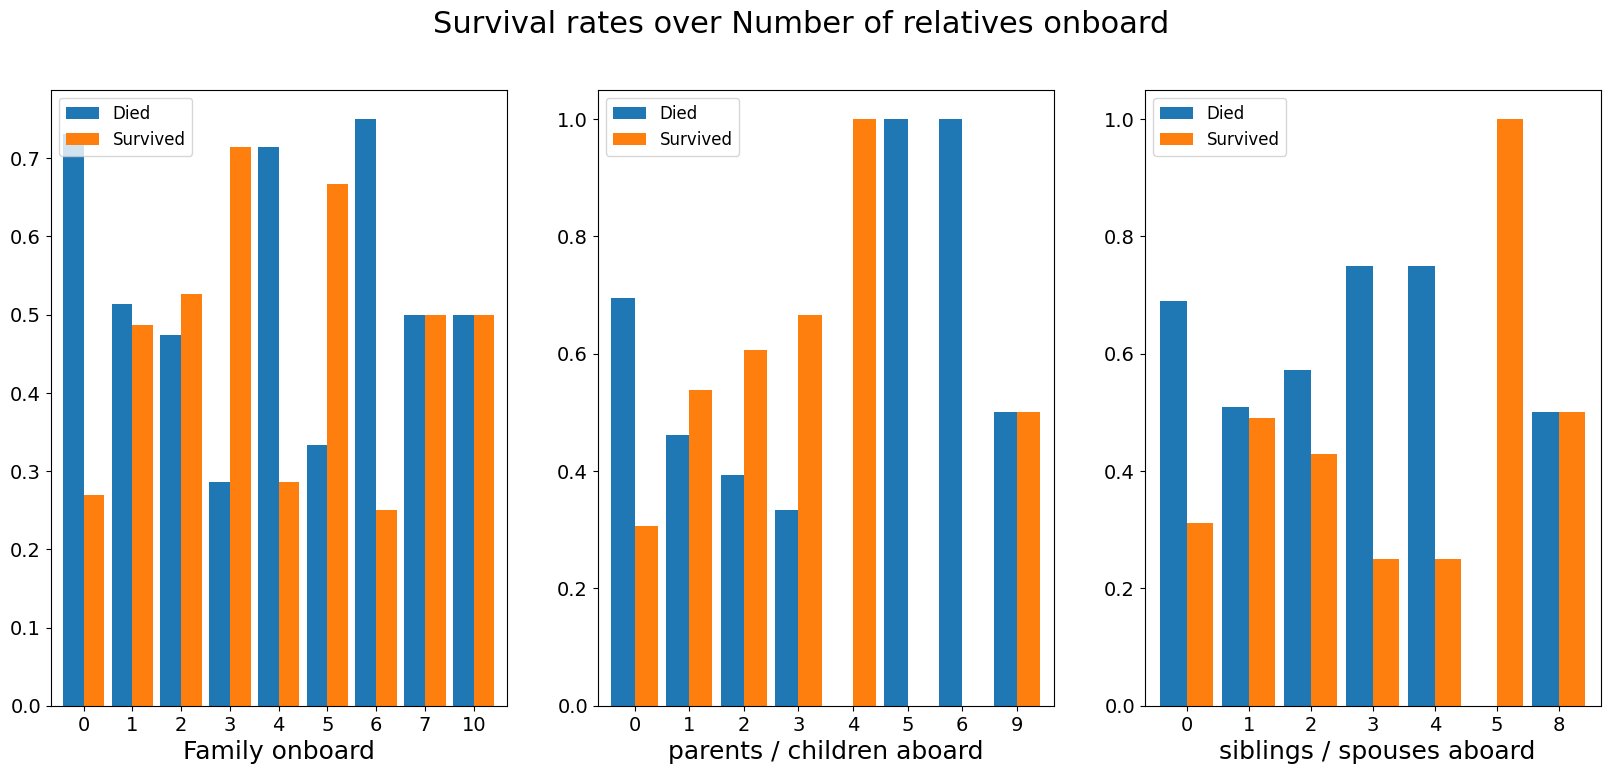

In [17]:
df_test['Family onboard'] = df_test['Parch'] + df_test['SibSp']
plt.rcParams['figure.figsize'] = [20, 8]
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

fig, axes = plt.subplots(nrows=1, ncols=3)
df_test.groupby(['Parch'])['Survived'].value_counts(normalize=True).unstack().plot.bar(ax=axes[1],width = 0.85)
df_test.groupby(['SibSp'])['Survived'].value_counts(normalize=True).unstack().plot.bar(ax=axes[2],width = 0.85)
df_test.groupby(['Family onboard'])['Survived'].value_counts(normalize=True).unstack().plot.bar(ax=axes[0],width = 0.85)

axes[0].set_xlabel('Family onboard',fontsize = 18)
axes[1].set_xlabel('parents / children aboard',fontsize = 18)
axes[2].set_xlabel(' siblings / spouses aboard',fontsize = 18)

for i in range(3):
    axes[i].legend(('Died','Survived'),fontsize = 12, loc = 'upper left')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)

plt.suptitle('Survival rates over Number of relatives onboard',fontsize =22)
plt.show()

<Figure size 600x500 with 0 Axes>

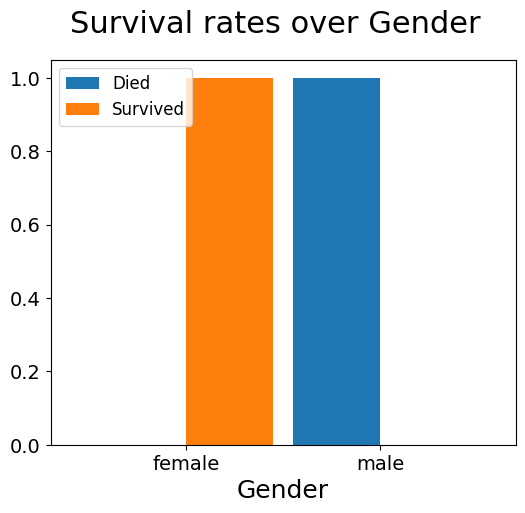

In [18]:
plt.rcParams['figure.figsize'] = [6, 5]
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

plt.figure()
fig = df_test.groupby(['Sex'])['Survived'].value_counts(normalize=True).unstack().plot.bar(width = 0.9)
plt.legend(('Died','Survived'),fontsize = 12, loc = 'upper left')
plt.xlabel('Gender',fontsize =18)
plt.xticks(rotation=0)

plt.suptitle('Survival rates over Gender',fontsize =22)
plt.show()

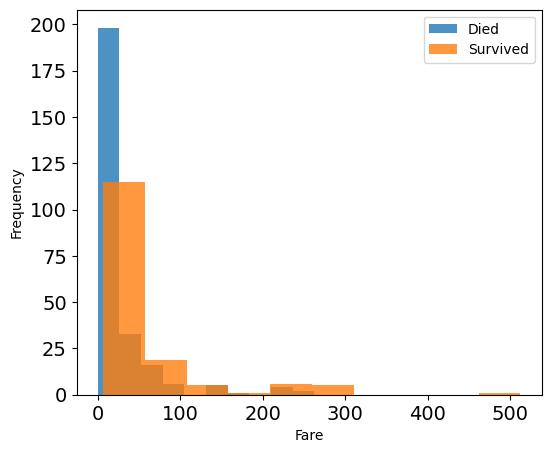

In [19]:
plt.figure()
fig = df_test.groupby('Survived')['Fare'].plot.hist(histtype= 'bar', alpha = 0.8)
plt.legend(('Died','Survived'))
plt.xlabel('Fare')
plt.show()

plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

In [22]:
df_test['Title'] = df_test['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip()
varnames = list(df_test.columns)
for name in varnames:
    print(name+": ",type(df_test.loc[1,name]))

print(list(df_test['Title'].unique()))
df_test['Title'] = df_test['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip()
df_test['Title'].unique()

PassengerId:  <class 'numpy.int64'>
Survived:  <class 'numpy.int64'>
Pclass:  <class 'numpy.int64'>
Name:  <class 'str'>
Sex:  <class 'str'>
Age:  <class 'numpy.float64'>
SibSp:  <class 'numpy.int64'>
Parch:  <class 'numpy.int64'>
Ticket:  <class 'str'>
Fare:  <class 'numpy.float64'>
Cabin:  <class 'float'>
Embarked:  <class 'str'>
Family onboard:  <class 'numpy.int64'>
Title:  <class 'str'>
['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona']


array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [23]:
def new_titles(df):
    new_titles = dict()
    assert 'Title' in df.columns
    for key in df['Title'].unique():
        females = ['Mrs','Miss','Ms','Mlle','Mme','Dona']
        males = ['Mr','Don']
        notable = ['Jonkheer','the Countess','Lady','Sir','Major','Col','Capt','Dr','Rev','Notable']
        titles = [females,males,notable,'Master']
        newtitles = ['Mrs','Mr','Notable','Master']
        idx = [key in sublist for sublist in titles]
        idx = np.where(idx)[0]
        new_titles[key] = newtitles[idx[0]]
    return new_titles


new_titles_dict = new_titles(df_test)
df_test['Title'] = df_test['Title'].replace(new_titles_dict)

<Figure size 1200x500 with 0 Axes>

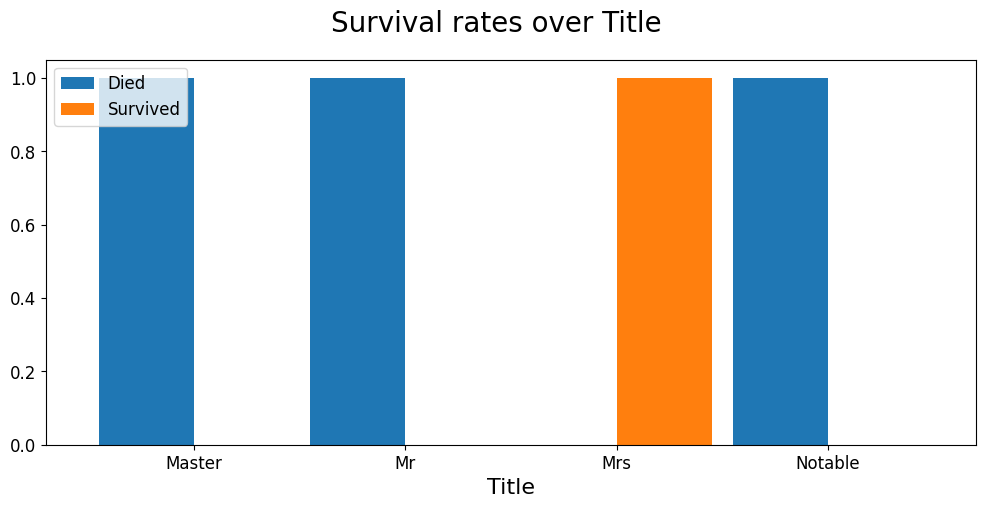

In [24]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

plt.figure()
fig = df_test.groupby(['Title'])['Survived'].value_counts(normalize=True).unstack().plot.bar(width = 0.9)
plt.legend(('Died','Survived'),fontsize = 12, loc = 'upper left')
plt.xlabel('Title',fontsize =16)
plt.xticks(rotation=0)


plt.suptitle('Survival rates over Title',fontsize =20)
plt.show()

In [27]:
df_test['Cabin'][df_test['Cabin'].isnull()]='Missing'
df_test['Cabin'] = df_test['Cabin'].str.split(r'(^[A-Z])',expand = True)[1]

<ipython-input-27-d32dbb005f24>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 1200x500 with 0 Axes>

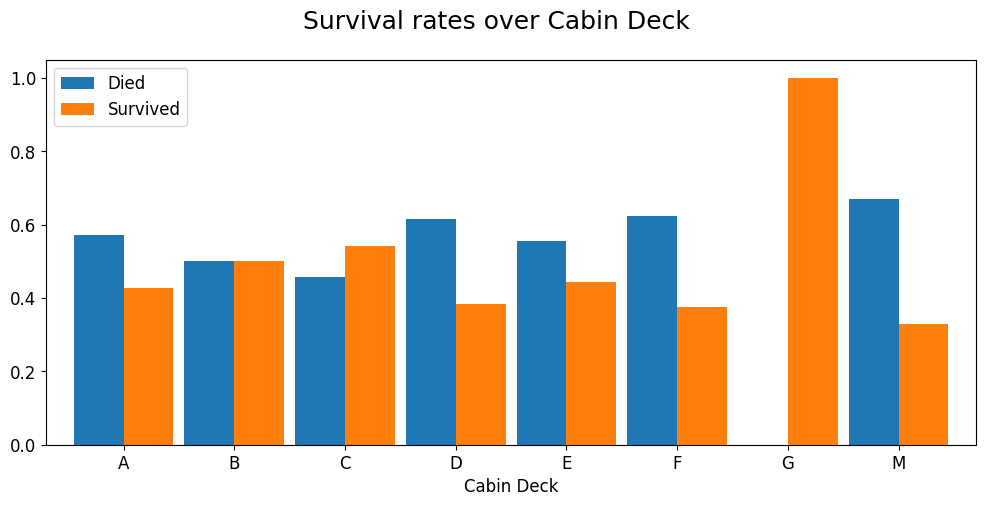

In [28]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.figure()
fig = df_test.groupby(['Cabin'])['Survived'].value_counts(normalize=True).unstack().plot.bar(width = 0.9)
plt.legend(('Died','Survived'),fontsize = 12, loc = 'upper left')
plt.xlabel('Cabin Deck',fontsize =12)
plt.suptitle('Survival rates over Cabin Deck',fontsize =18)
plt.xticks(rotation=0)
plt.show()

<Figure size 1000x500 with 0 Axes>

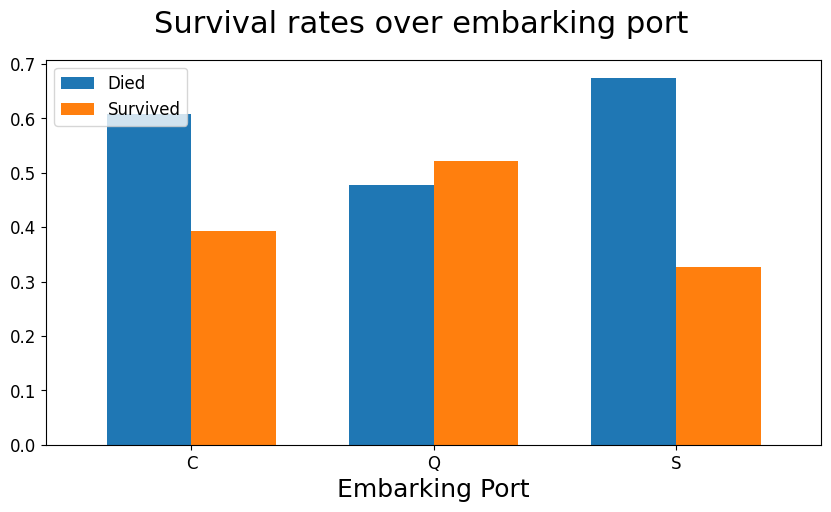

In [29]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
fig = df_test.groupby(['Embarked'])['Survived'].value_counts(normalize=True).unstack().plot.bar(width = 0.7)
plt.legend(('Died','Survived'),fontsize = 12, loc = 'upper left')
plt.xlabel('Embarking Port',fontsize =18)
plt.suptitle('Survival rates over embarking port',fontsize =22)
plt.xticks(rotation=0)
plt.show()

In [30]:
def df_fill(datasets, mode):
    assert mode =='median' or mode =='sampling'
    datasets_cp =[]
    np.random.seed(2)
    varnames = ['Age','Fare']
    for d in datasets:
        df = d.copy(deep = True)
        for var in varnames:
            idx = df[var].isnull()
            if idx.sum()>0:
                if mode =='median':
                    medians = df.groupby('Pclass')[var].median()
                    for i,v in enumerate(idx):
                        if v:
                            df[var][i] = medians[df['Pclass'][i]]
                else:
                    g = df[idx==False].groupby('Pclass')[var]
                    for i,v in enumerate(idx):
                        if v:
                            df[var][i] = np.random.choice((g.get_group(df['Pclass'][i])).values.flatten())
    #Embarked
        idx = df['Embarked'].isnull()
        g = df[idx==False].groupby('Pclass')['Embarked']
        for i,v in enumerate(idx):
            if v:
                df['Embarked'][i] = np.random.choice((g.get_group(df['Pclass'][i])).values.flatten())
    #Cabin
        df['Cabin'][df['Cabin'].isnull()]='Missing'
        df['Cabin'] = df['Cabin'].str.split(r'(^[A-Z])',expand = True)[1]
        datasets_cp.append(df)
    return datasets_cp

data_clean = df_fill(data_cleaner,'median')

<ipython-input-30-bc7d3fd9cbc8>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-bc7d3fd9cbc8>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-bc7d3fd9cbc8>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
def prepare_data(datasets):
        datasets_cp = []
        for d in datasets:
            df = d.copy(deep = True)
            df['Family onboard'] = df['Parch'] + df['SibSp']
            df['Title'] = df['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip()
            new_titles_dict = new_titles(df)
            df['Title'] = df['Title'].replace(new_titles_dict)
            df.drop(columns = ['PassengerId','Name','Ticket'],axis = 1, inplace = True)
            datasets_cp.append(df)
        return datasets_cp

In [34]:
print("Test data")
print(df_test.isnull().sum())

Test data
PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age               86
SibSp              0
Parch              0
Ticket             0
Fare               1
Cabin              0
Embarked           0
Family onboard     0
Title              0
dtype: int64


In [52]:
def corr_matrix(x,y, quant = None):
    x_quants = x.quantile(quant) if quant else x.quantile([0, 0.25, 0.5, 0.75, 1])
    out = np.zeros((x_quants.shape[0]-1,int(y.unique().max()+1)))
    for i in range(x.shape[0]):
        comp = x[i]<=x_quants
        idx = int(next((j for j,compv in enumerate(comp) if compv),None))
        out[idx-1,int(y[i])]+=1
    return out.T,x_quants

def plot_corr_matrix(x,quants,fig, ax, **kwargs):
    assert x.shape[1] == quants.shape[0]-1
    cmap = kwargs['cmap'] if kwargs['cmap'] else 'Blues'
    ax.set_xlabel(kwargs['xlabel'])
    ax.set_ylabel(kwargs['ylabel'])
    ticks = np.arange(quants.shape[0])
    ax.set_xticks(ticks)
    ax.set_xticklabels(list(quants))
    if 'xlabel' and 'ylabel' in kwargs.keys():
        ax.title.set_text(f"{kwargs['xlabel']} vs {kwargs['ylabel']}")
    p = ax.pcolor(x,cmap = cmap)
    fig.colorbar(p,ax = ax)
    return fig,ax

def gen_corr_matrix(*args,quant = None,cmap = 'YlOrBr'):
    totalvars = len(args)
    assert totalvars>1

    out   = dict()
    out_q = dict()
    fig,axs = plt.subplots(1, totalvars-1, squeeze=False)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    fig.figsize=(800, 800)
    fig.suptitle("Correlation Matrix") if totalvars<3 else fig.suptitle("Correlation Matrices")
    for i in range(totalvars-1):
        out[i],out_q[i] = corr_matrix(args[0],args[i+1],quant)
        plot_corr_matrix(out[i], out_q[i],
                         fig,
                         axs[0,i],
                         cmap = cmap ,
                         xlabel = args[0].name,
                         ylabel = args[i+1].name)
    plt.show()

In [42]:
df_test.dropna()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family onboard,Title
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,M,Q,0,Mr
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,M,S,1,Mrs
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,M,Q,0,Mr
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,M,S,0,Mr
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,M,S,2,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,1301,1,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,M,S,2,Mrs
411,1303,1,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C,Q,1,Mrs
412,1304,1,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,M,S,0,Mrs
414,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,C,0,Mrs


In [47]:
print(df_test[['Age', 'Fare']].isnull().sum())

Age     86
Fare     1
dtype: int64


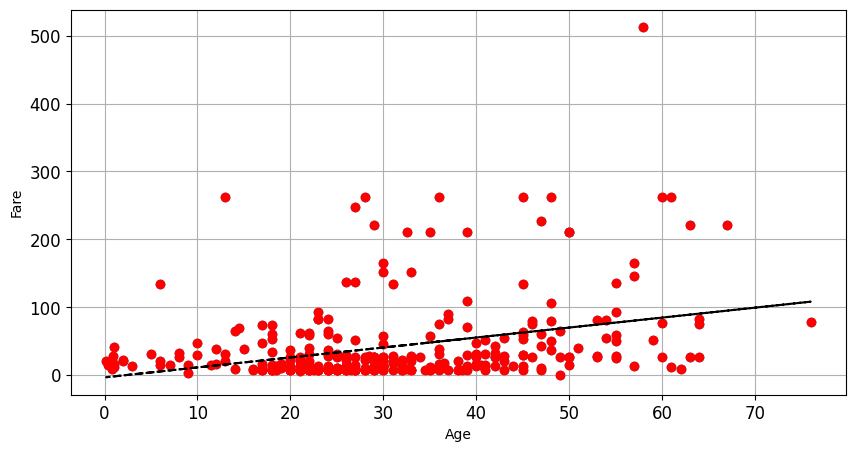

In [48]:
df_cleaned = df_test[['Age', 'Fare']].dropna()
scatterplot(df_cleaned['Age'], df_cleaned['Fare'])

In [49]:
print(df_test[['Age', 'Fare']].dtypes)


Age     float64
Fare    float64
dtype: object


In [50]:
df_test['Age'] = pd.to_numeric(df_test['Age'], errors='coerce')
df_test['Fare'] = pd.to_numeric(df_test['Fare'], errors='coerce')